In [10]:
from os import path
import glob
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('apw-notebook.mplstyle')
%matplotlib inline
import sklearn
from astropy.table import Table

__Note: this line will take a while the first time you execute it! It needs to download some images:__

In [11]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=32)

# Dimensionality reduction

Astronomical data is often "big data" in two ways: many objects _and_ many features. For example, a spectroscopic survey -- you can think of the fluxes measured at each wavelength as being individual features! In that context, each object or data point could have ~1000's of features. With data that is this high-dimensional, how do you visualize it? How do you know where the information is? 

We know from other work that stellar spectra can be characterized typically by just a few parameters, things like $T_{\rm eff}$, $\log g$, $[{\rm Fe}/{\rm H}]$, etc. This suggests that there is a mapping from "fluxes" to some much lower-dimensional space that preserves most of the information. You might call this "learning the parameters of a model," "data compression," or "feature extraction" (or all). The goal of dimensionality reduction is to approximate this transformation while preserving most of the _information_. PCA is a particular dimensionality reduction method that uses a linear transformation for this step. PCA therefore corresponds to projecting the data onto a set of vectors aligned with the directions of maximum _variance_ in the data.

Why does more variance correspond to more information? Imagine 2D distribution of points aligned with axes with large variance in one direction, small variance in the other:

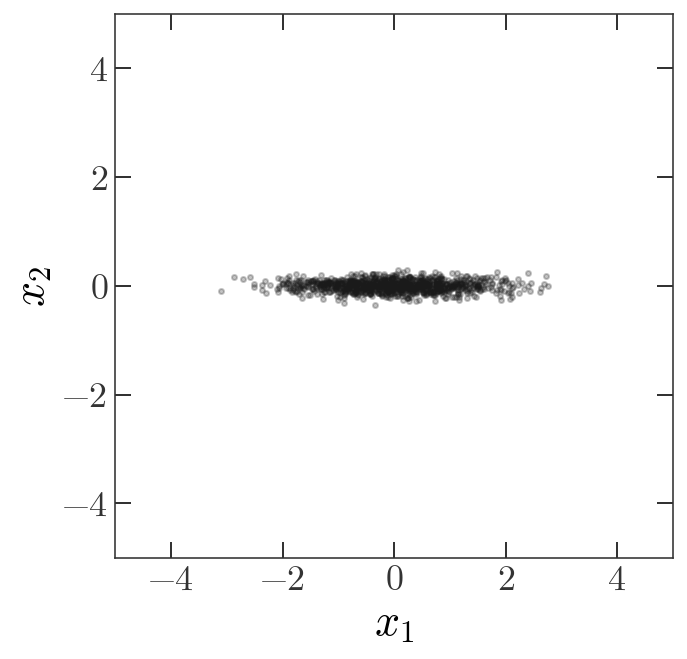

In [12]:
x = np.random.normal(0, 1., size=1024)
y = np.random.normal(0, 0.1, size=x.size)

plt.figure(figsize=(5,5))
plt.scatter(x, y, alpha=0.25, marker='.')
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

The feature $x_2$ is not very informative, i.e. the data have a small variance in this dimension. We would therefore preserve most of the information about the data by ignoring this dimension and just using $x_1$ in whatever classification problem or analysis we do with the data. For small numbers of dimensions, reducing the dimensionality doesn't help much in analysis, visualization, storage, etc. But for large numbers of dimensions, reducing the dimensionality can be crucial for interpretability or making problems tractable.

## Principal Component Analysis (PCA)

_Disclaimer: There are a number of ways to interpret or present the concepts behind PCA -- this is just the way I think of it!_

The "principal components" of a dataset are the eigenvectors of the empirical covariance matrix of the data ordered by the magnitude of the corresponding eigenvalues. As a procedure, PCA is just a projection of the original data onto a subspace defined by a subset of the eigenvectors. Let's unpack that a bit...

Let's imagine we observe a few quantities (features) that end up being highly correlated, say, the size and the absolute magnitude of a bunch of galaxies

In [13]:
X = np.loadtxt('../data/correlated_data.csv', delimiter=',')
X.shape

(1024, 3)

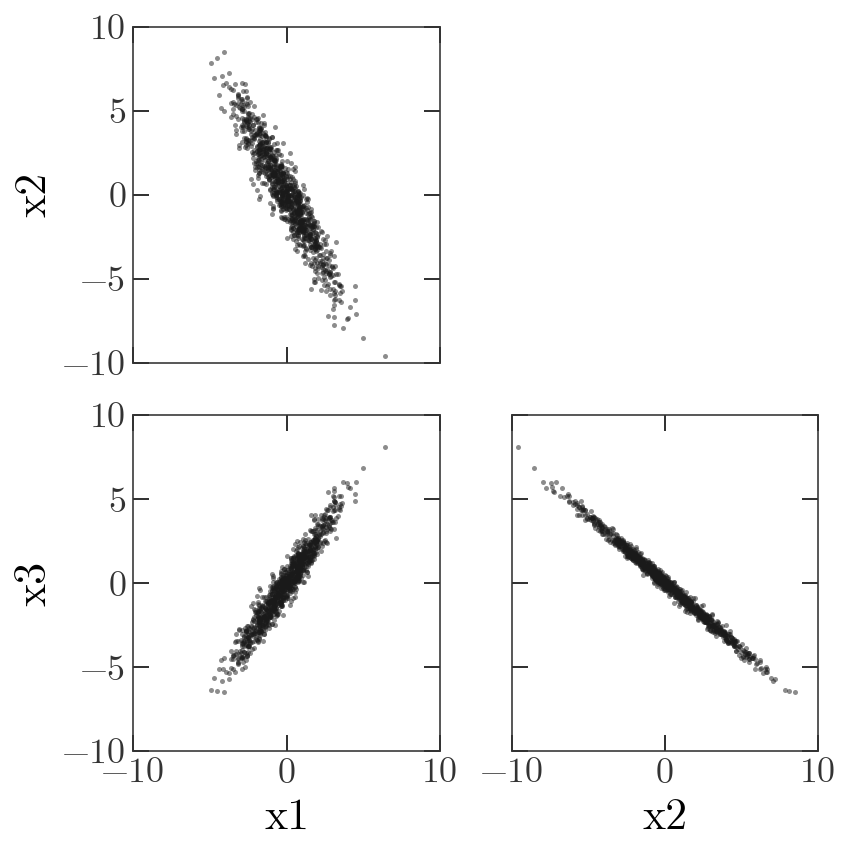

In [14]:
fig,axes = plt.subplots(2, 2, figsize=(6,6), sharex=True, sharey=True)

axes[0,0].plot(X[:,0], X[:,1], marker='.', alpha=0.5, linestyle='none')
axes[1,0].plot(X[:,0], X[:,2], marker='.', alpha=0.5, linestyle='none')
axes[1,1].plot(X[:,1], X[:,2], marker='.', alpha=0.5, linestyle='none')

axes[0,0].set_ylabel('x2')
axes[1,0].set_ylabel('x3')
axes[1,0].set_xlabel('x1')
axes[1,1].set_xlabel('x2')

axes[0,0].set_xlim(-10, 10)
axes[0,0].set_ylim(-10, 10)
fig.tight_layout()
axes[0,1].set_visible(False)

Most of the variance in these data is along one particular direction; we might therefore be able to do some analysis of this data by considering just that direction. But in general, that vector might be some combination of the data that you measure. With PCA, we assume that the eigenvectors computed from the empirical covariance matrix describe these directions. If we rank the eigenvectors by the eigenvalues, the directions will be in decreasing importance:

In [15]:
Cov = np.cov(X.T)
eig_vals, eig_vecs = np.linalg.eig(Cov)

We sort by the eigenvalues and project the data onto the eigenbasis. The 0th feature is now the most informative, and so on.

In [16]:
idx = eig_vals.argsort()
Y = X[:,idx] @ eig_vecs[idx] # projection

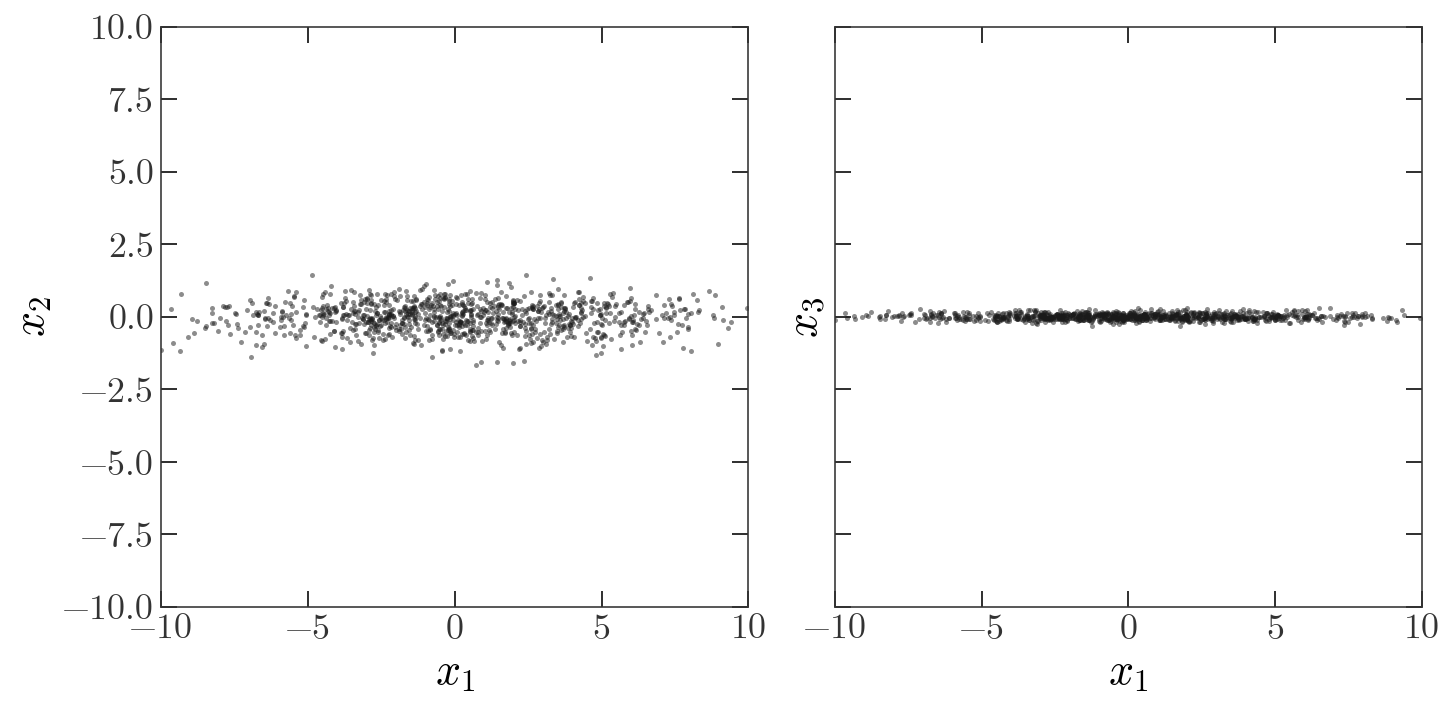

In [17]:
fig,axes = plt.subplots(1, 2, figsize=(10,5), sharex=True, sharey=True)

axes[0].plot(Y[:,0], Y[:,1], marker='.', alpha=0.5, linestyle='none')
axes[1].plot(Y[:,0], Y[:,2], marker='.', alpha=0.5, linestyle='none')

axes[0].set_xlim(-10, 10)
axes[0].set_ylim(-10, 10)

axes[0].set_xlabel('$x_1$')
axes[0].set_ylabel('$x_2$')
axes[1].set_xlabel('$x_1$')
axes[1].set_ylabel('$x_3$')

fig.tight_layout()

One way to quantify how much variance or information is contained along each eigenvector is to compute the _cumulative explained variance_. This tells you, at a given eigenvector, what fraction the total variance is explained by the given eigenvector and all eigenvectors preceding it (with larger eigenvalues). Heres the CEV for the example above:

In [18]:
np.cumsum(eig_vals) / np.sum(eig_vals)

array([ 0.98409181,  0.99938294,  1.        ])

This tells us that the 0th eigenvector *alone* contains ~98% of the variance of the distribution, and 99.9% is contained with the first two. You have to decide what fraction of the explained variance is OK with you, and truncate the eigenvectors there. Here, if we arbitrarily say we want >95% of the explained variance, we would just keep the first eigenvector.

---

## Example: Eigenfaces

Here we're going to do an example of PCA with some more interesting, high-dimensional data: pictures of faces. Each image is 62 x 47 (why would they do that to us!), so if we treat each pixel as a feature, that's 2914 features *per image* or *per object*. We'll do a PCA on that large feature-space and see how many "eigenfaces" we need to explain 95% of the variance (i.e. do a pretty good job at representing faces).

_Note: this is heavily inspired by Jake Vanderplas' [notebook]( https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.09-Principal-Component-Analysis.ipynb)_.

In [19]:
from PIL import Image
from sklearn.decomposition import PCA

In [20]:
# fetch the face image data
faces = fetch_lfw_people(min_faces_per_person=32)

In [21]:
faces.images.shape, faces.data.shape

((2248, 62, 47), (2248, 2914))

Here's a sample of what some of the images look like:

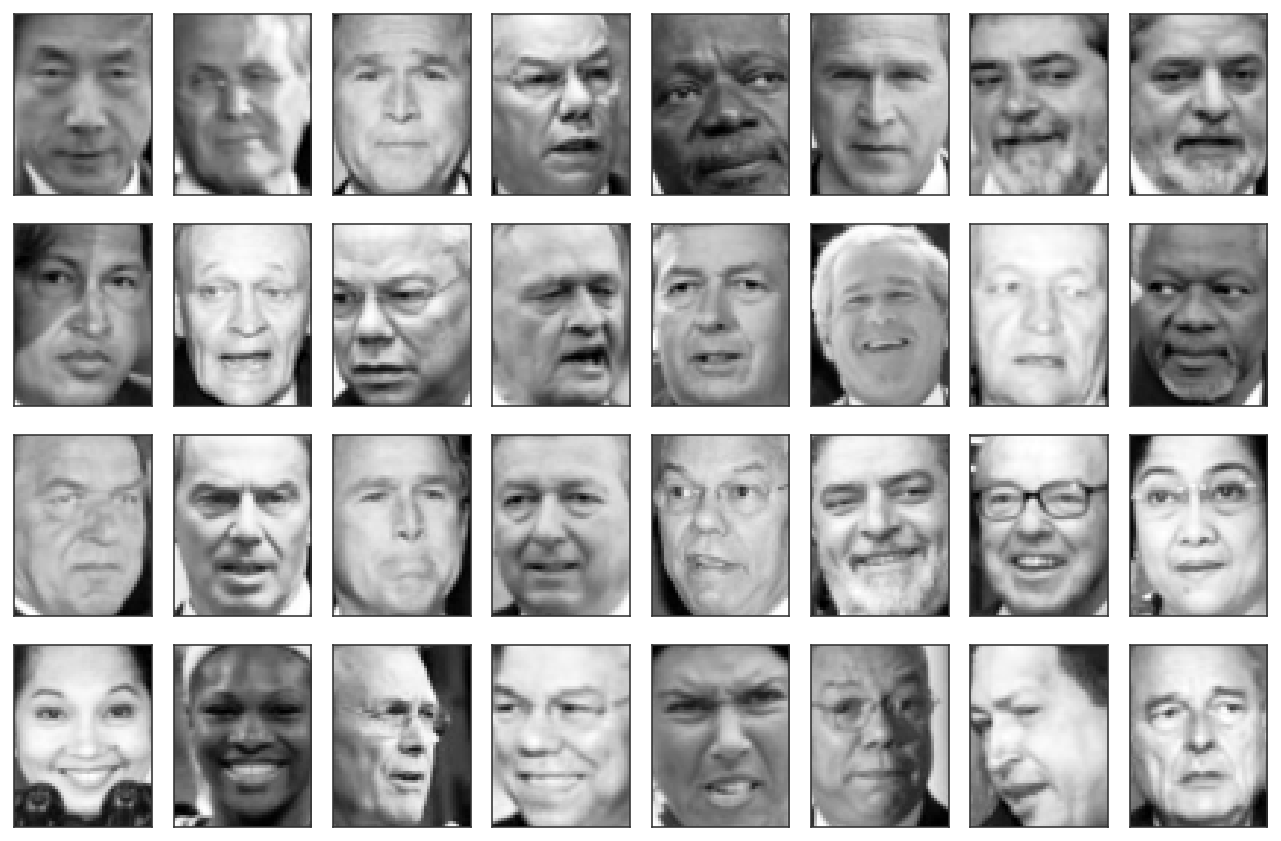

In [22]:
fig, axes = plt.subplots(4, 8, figsize=(9, 6),
                         subplot_kw={'xticks':[], 'yticks':[]})

for i, ax in enumerate(axes.flat):
    ax.imshow(faces.images[i], cmap='Greys_r')
    
fig.tight_layout()

We can also plot the pixel "flux" values as if the are features / dimensions of the data. Here are a few projections of the data:

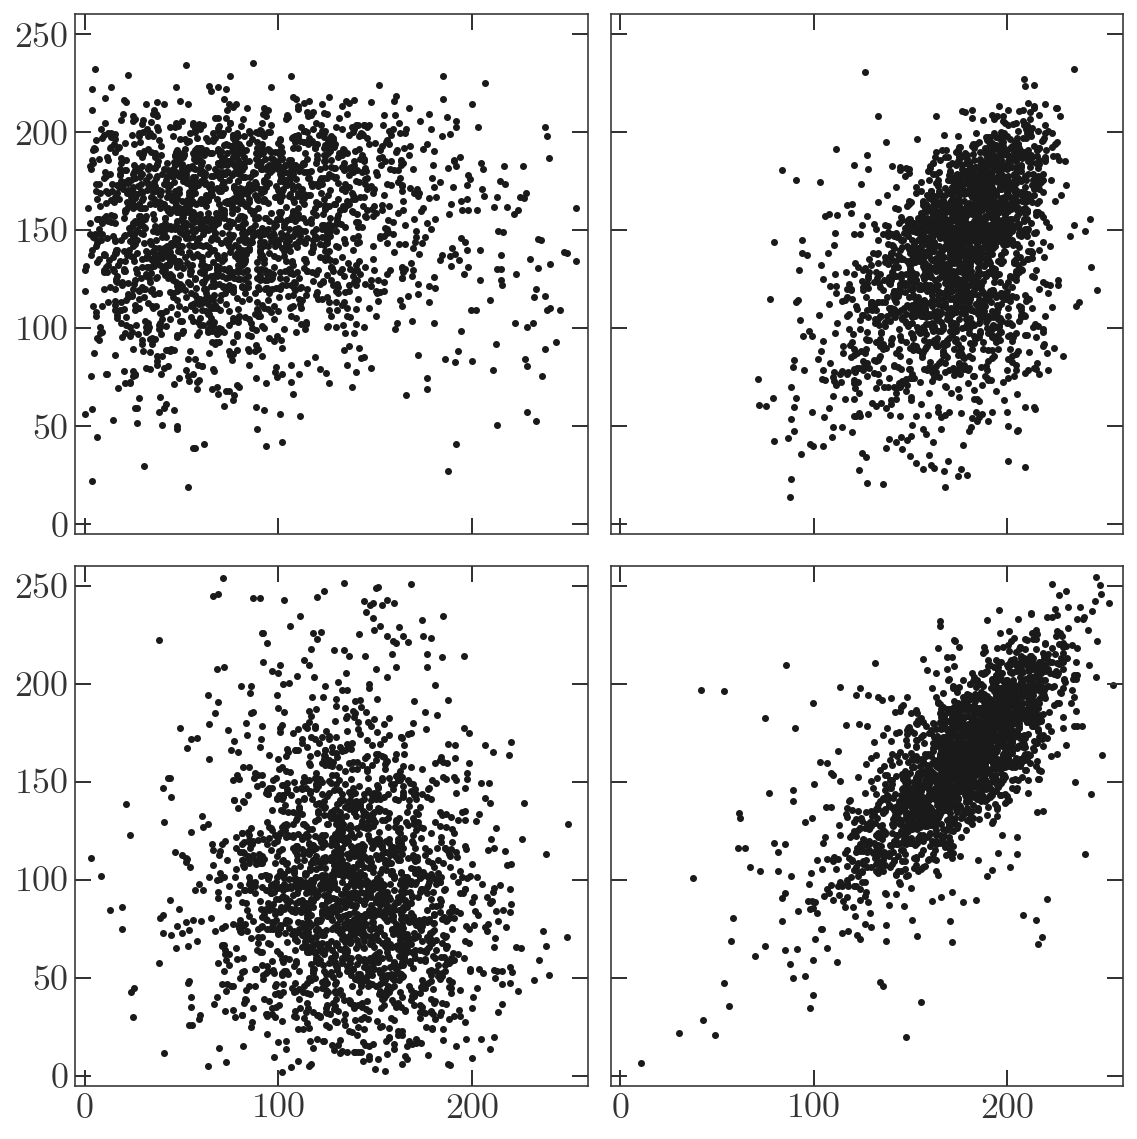

In [23]:
fig,axes = plt.subplots(2, 2, figsize=(8,8), sharex=True, sharey=True)

axes[0,0].scatter(faces.images[:,0,0], faces.images[:,32,16], marker='.')
axes[0,1].scatter(faces.images[:,11,21], faces.images[:,25,13], marker='.')
axes[1,0].scatter(faces.images[:,13,41], faces.images[:,59,12], marker='.')
axes[1,1].scatter(faces.images[:,2,20], faces.images[:,4,11], marker='.')

axes[0,0].set_xlim(-5, 260)
axes[0,0].set_ylim(-5, 260)

fig.tight_layout()

Let's now perform a PCA on the image data, and keep the largest 256 eigenvectors (which are actually images). Here, we'll use the PCA implementation in `scikit-learn` which actually doesn't compute eigenvectors (it does an SVD on the input data) and is a bit more numerically stable:

In [24]:
pca = PCA(256)
pca.fit(faces.data)

PCA(copy=True, iterated_power='auto', n_components=256, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Let's visualize the top eigenfaces:

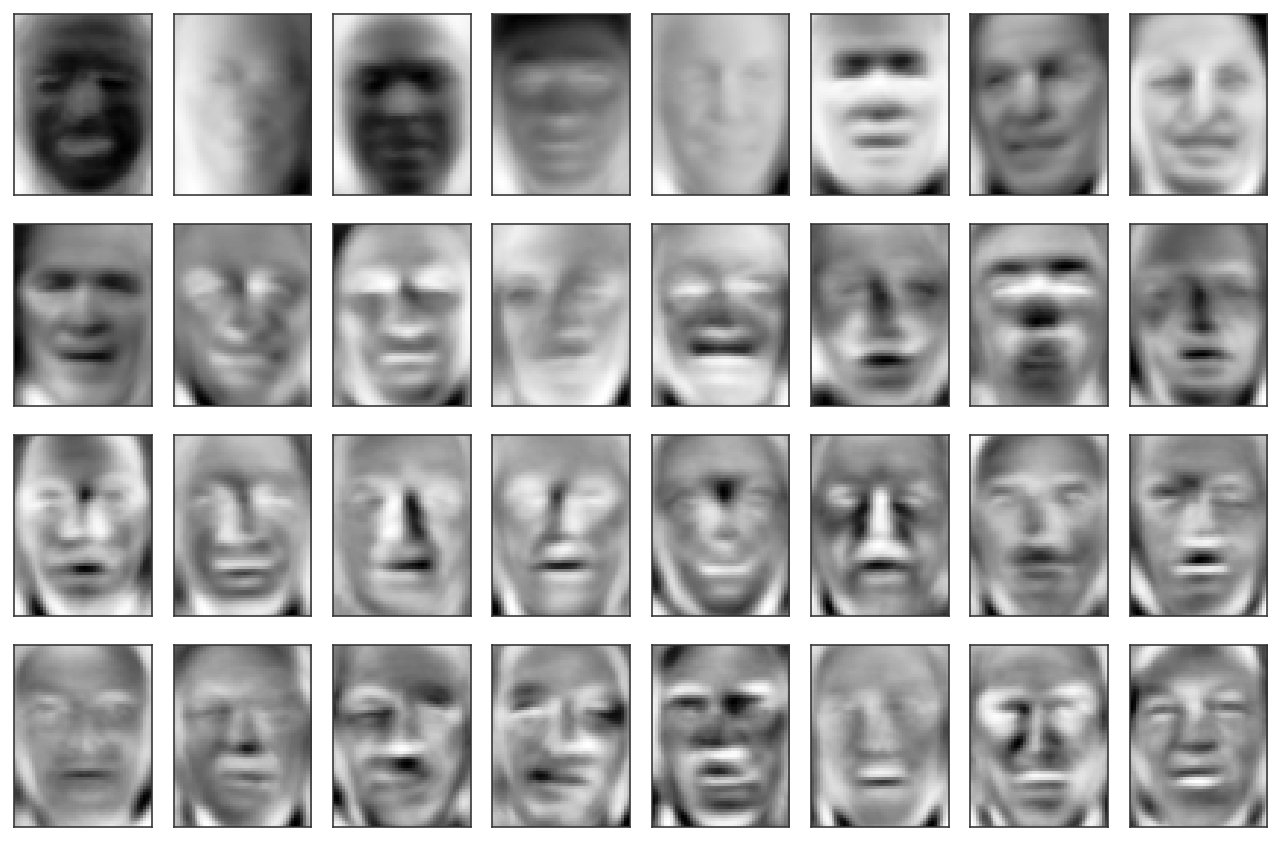

In [25]:
fig, axes = plt.subplots(4, 8, figsize=(9, 6),
                         subplot_kw={'xticks':[], 'yticks':[]})

for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(62, 47), cmap='Greys_r')
    
fig.tight_layout()

Apart from being slightly terrifying, it's cool! You can see components needed for shading faces, making eyes darker, making noses wider, etc. Let's look at the cumulative explained variance:

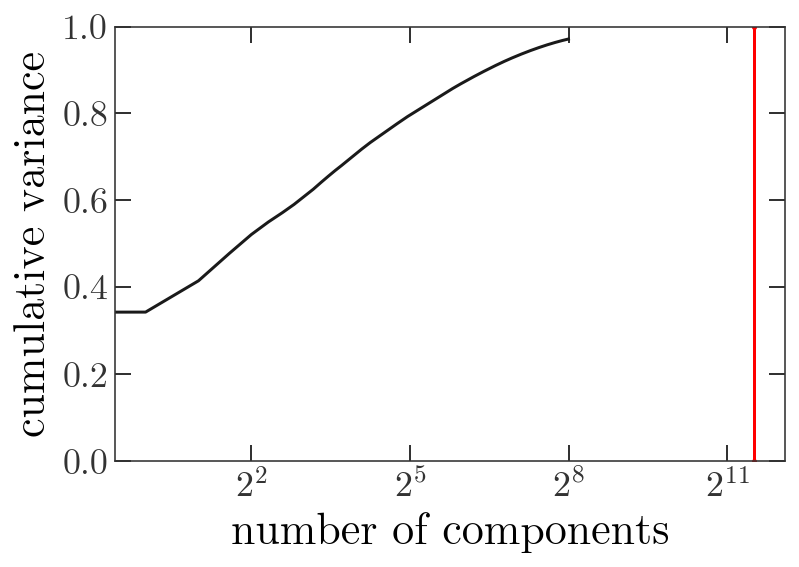

In [26]:
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='')
plt.xlabel('number of components')
plt.ylabel('cumulative variance');
plt.ylim(0, 1)
plt.xscale('log', basex=2)
plt.axvline(faces.images[0].size, color='r')

The red line is at 2914, the number of input features. How many eigenfaces do we need to use to preserve 95% of the variance?

In [27]:
np.argmin(np.abs(np.cumsum(pca.explained_variance_ratio_) - 0.95))

169

Only 170! That's a big data compression.

Let's see how the quality of the predicted faces depend on how many eigenfaces you include:

In [28]:
face_data = faces.data
image_shape = faces.images[0].shape

In [32]:
def do_pca(n_components):
    fig, ax = plt.subplots(2, 8, figsize=(16, 6),
                           subplot_kw={'xticks':[], 'yticks':[]})

    pca = PCA(n_components)
    pca.fit(face_data)

    for i in range(16):
        components = pca.transform(face_data[i].reshape(1, -1))
        projected = pca.inverse_transform(components)
        ax.flat[i].imshow(projected[0].reshape(image_shape), cmap='binary_r')

    fig.suptitle('{}-dim reconstruction'.format(pca.n_components), fontsize=24)

    fig.tight_layout()

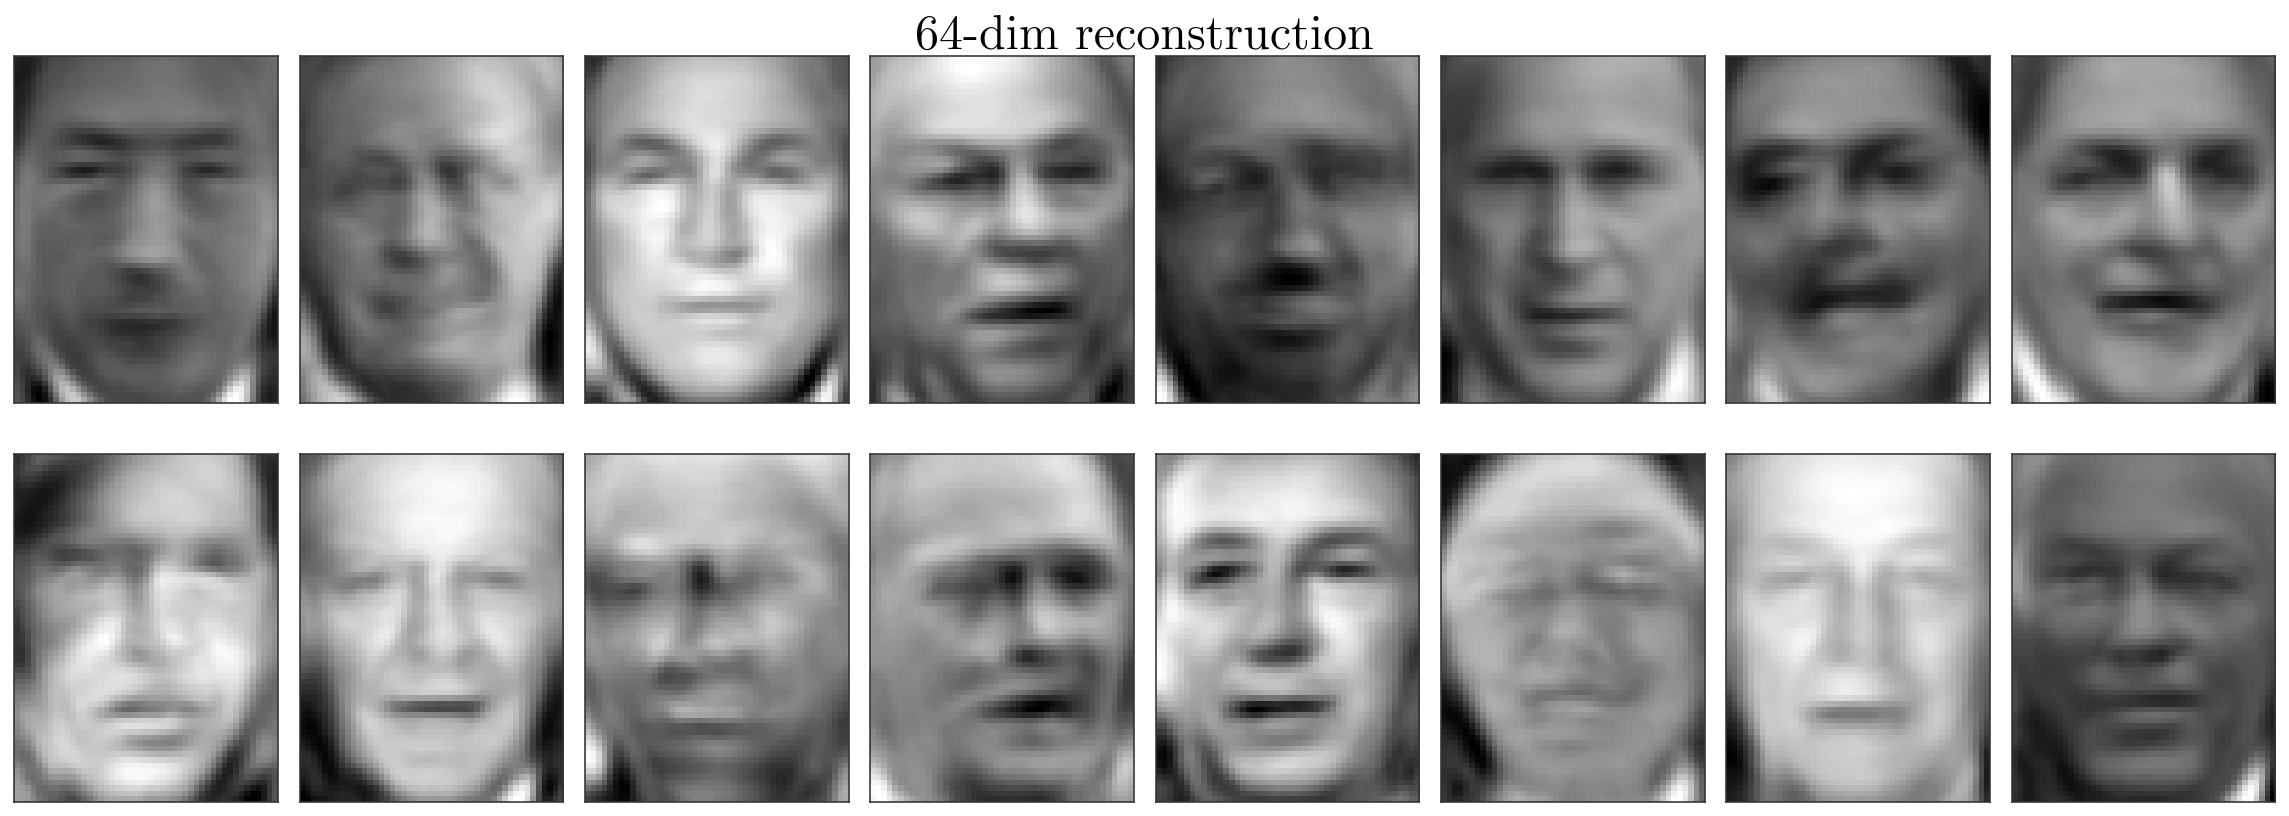

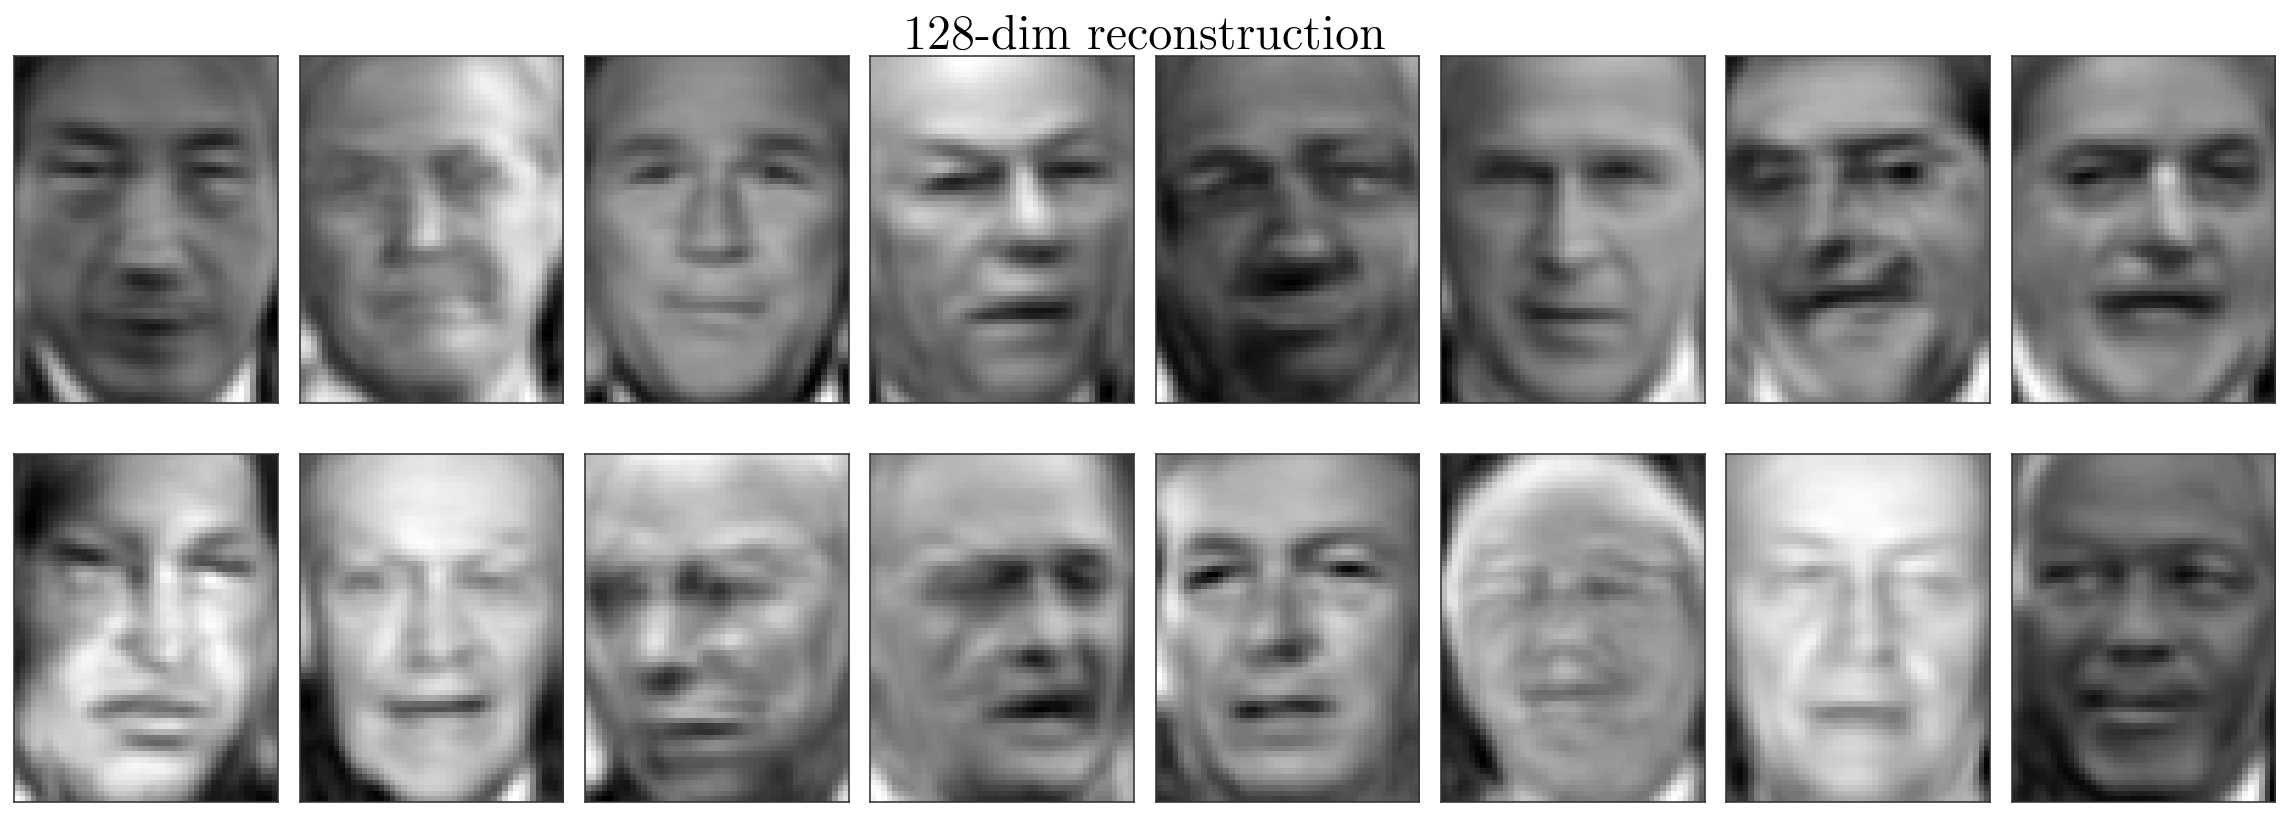

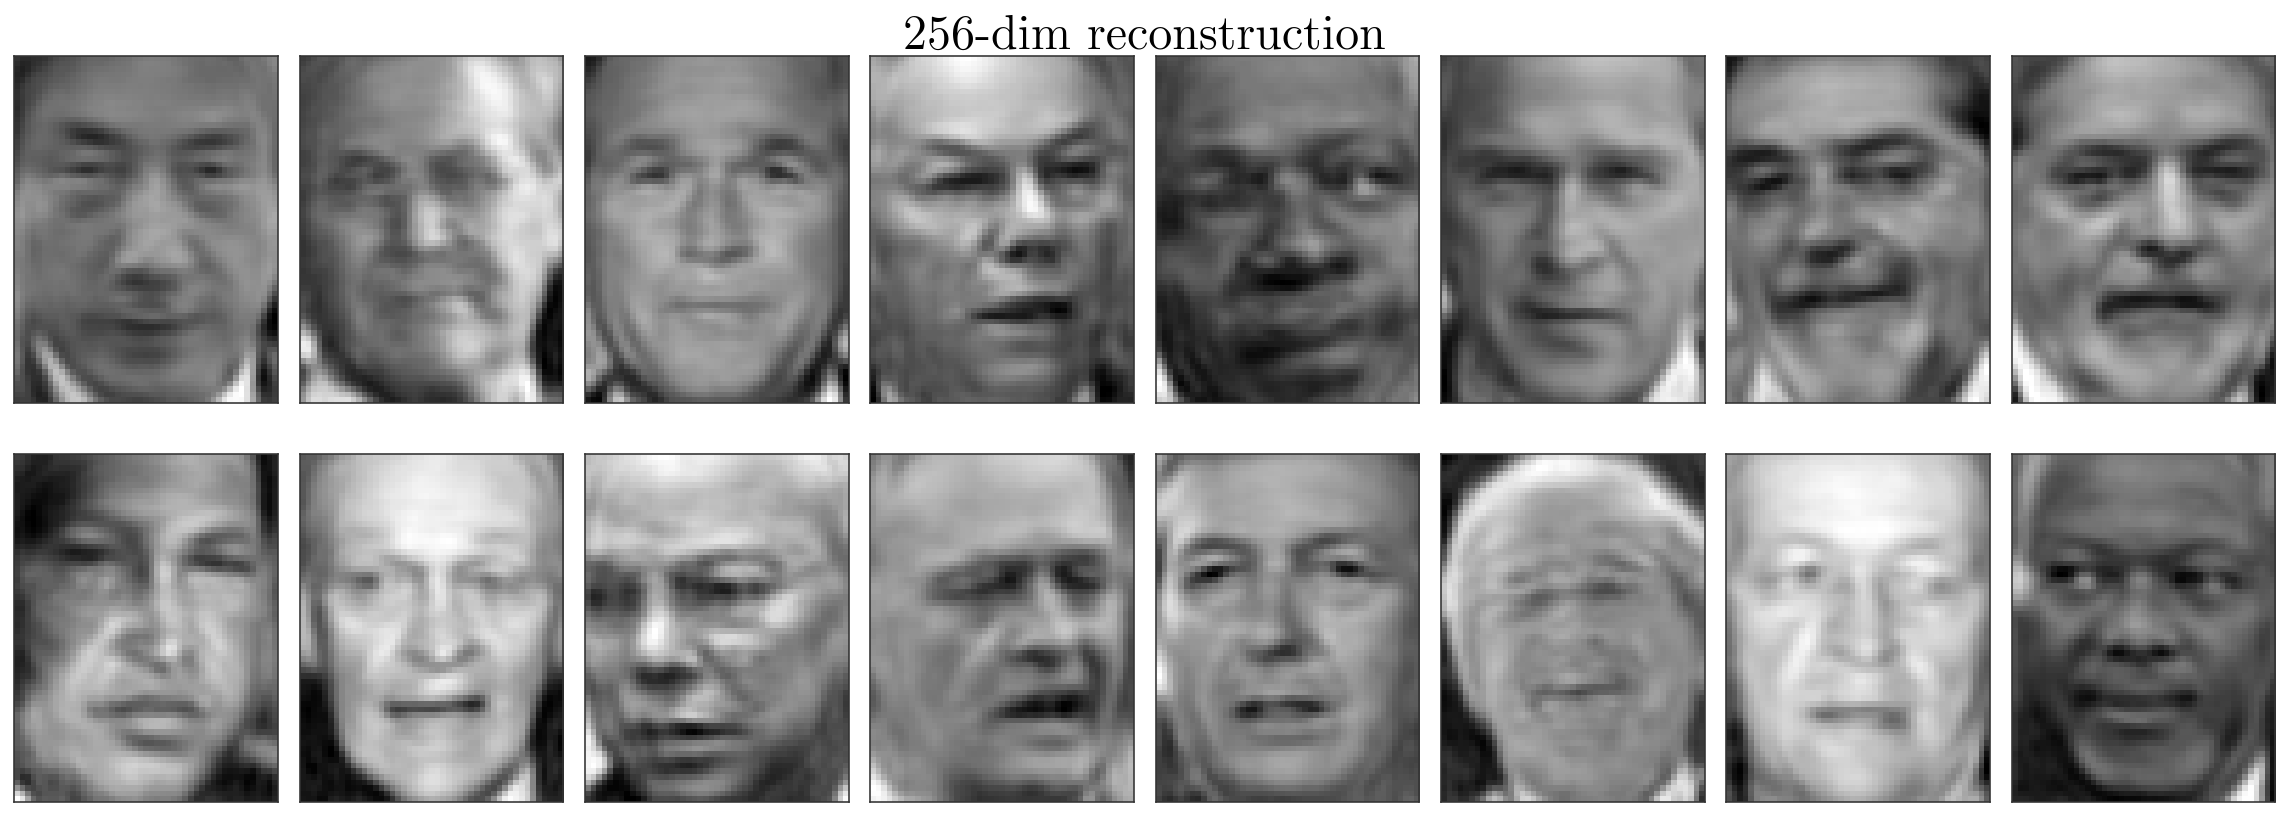

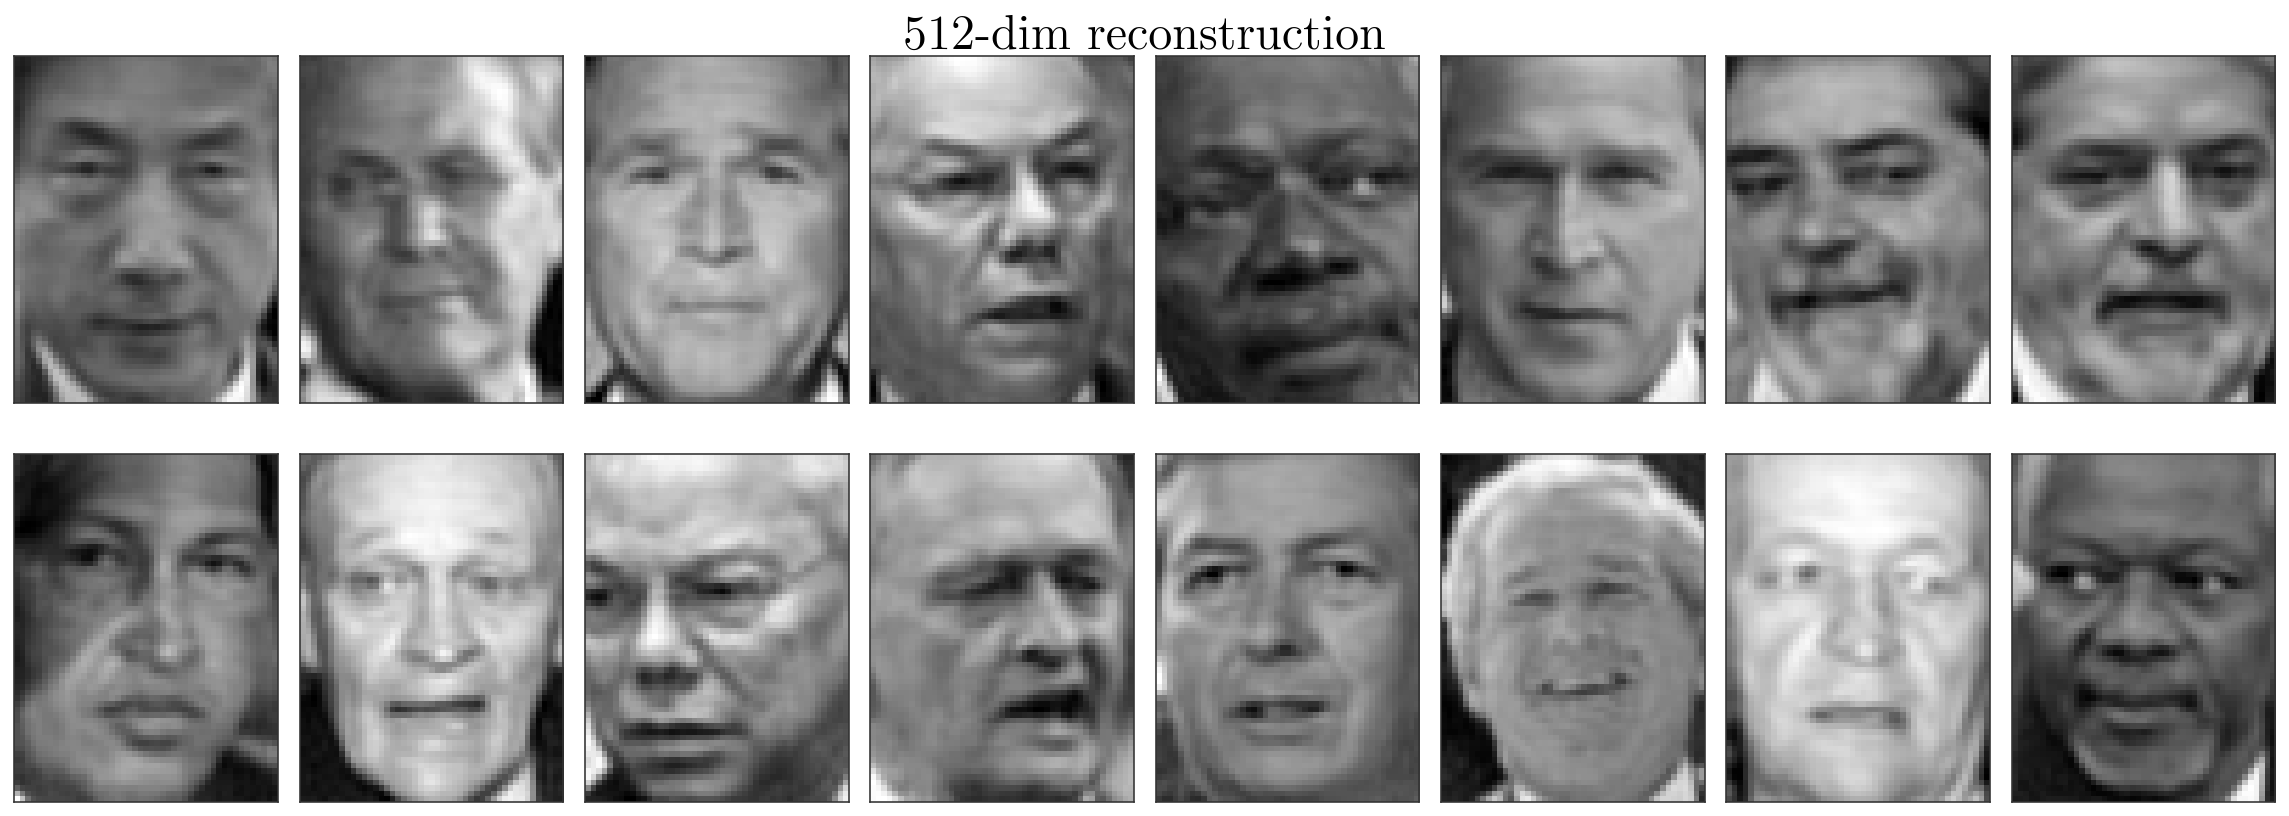

In [33]:
for n in [64, 128, 256, 512]:
    do_pca(n)

Now let's visualize where these familiar faces lie in projections of the most informative eigenvectors:

In [36]:
pca = PCA(64)
pca.fit(face_data)
compressed_data = pca.transform(face_data)

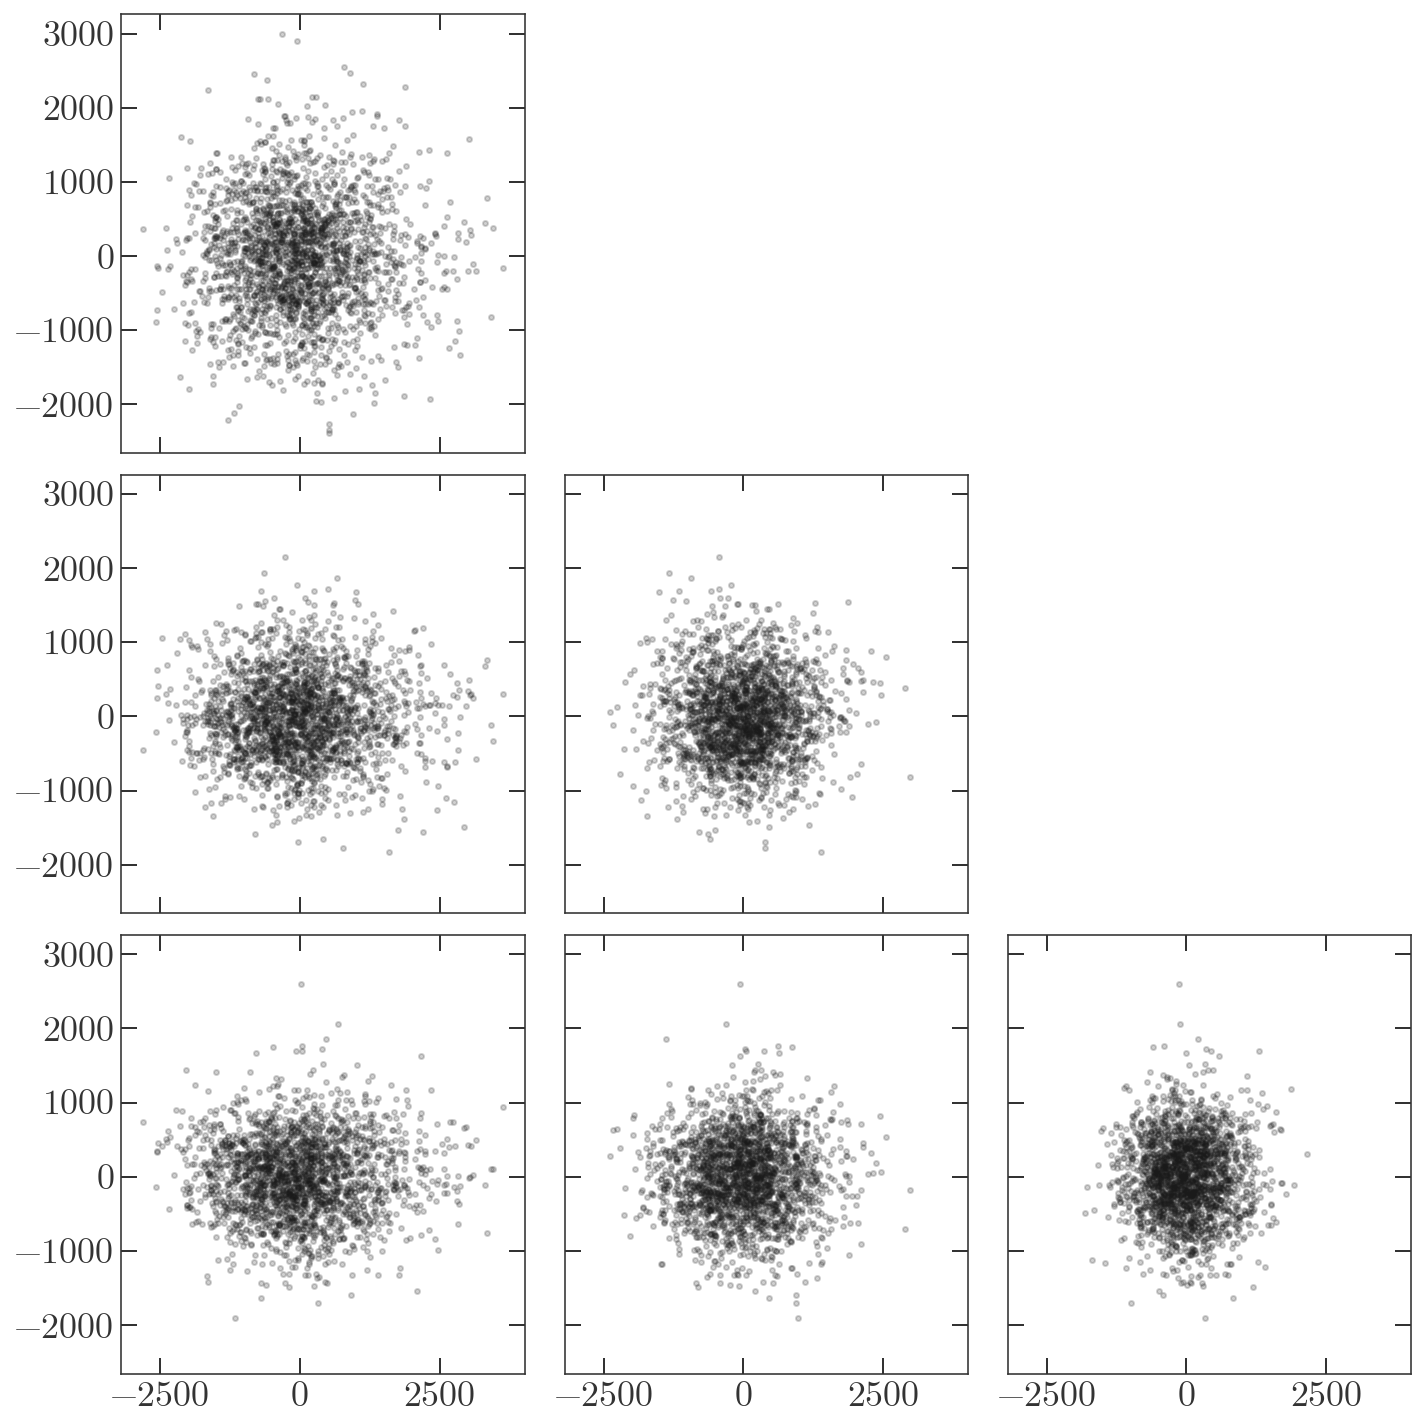

In [40]:
fig,axes = plt.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)

for i in range(3):
    for j in range(3):
        if j > i: continue
        axes[i,j].scatter(compressed_data[:,j], compressed_data[:,i+1], 
                          marker='.', alpha=0.2)

fig.tight_layout()
        
for i in range(3):
    for j in range(3):
        if j > i: axes[i,j].set_visible(False)

__Question__: What are some of the key limitations to doing this in the Real World?

* Uncertainties
* Data have to be drawn from a linear subspace of the full spectral space. 
* Trouble separating amplitude changes (overall flux or luminosity changes) from shape changes
* No idea about prior information; it is just as happy creating components with negative amplitudes as positive amplitudes, many spectra have completely unphysical properties